# Importing required packages.
This section imports the necessary libraries specifically for implementing the **KNN classifier** and evaluating its performance.

In [1]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial import distance
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Train KNN Classifier with Euclidean Distance Calculation

📘 Purpose:
This section demonstrates how KNN with (k=1) classifies a new data point by calculating Euclidean distance to all training samples.

💡 Why this step?

- To manually simulate what KNN does internally: finding the "nearest" training sample.
- Helps understand how distance metrics impact classification.
- Euclidean distance is one of the most common choices for continuous, numerical features.

📏 Distance formula used: d(x,x'_ = sqrt(sum(xi-x'i)^2)

We compute this between the first test sample and each training sample.

In [2]:
# Load preprocessed and scaled data from .pkl files
X_train = joblib.load('/home/jovyan/work/glow2025_final_project/X_train.pkl')
X_test = joblib.load('/home/jovyan/work/glow2025_final_project/X_test.pkl')
y_train = joblib.load('/home/jovyan/work/glow2025_final_project/y_train.pkl')
y_test = joblib.load('/home/jovyan/work/glow2025_final_project/y_test.pkl')

# Example: Train KNN with k=1
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Show manual Euclidean distance for first test sample
print("🔢 Manual Euclidean Distance Calculation (first test sample):")
dists = [np.sqrt(np.sum((x - X_test[0]) ** 2)) for x in X_train]
nearest_index = np.argmin(dists)
print(f"Closest training sample index: {nearest_index}, Label: {y_train.iloc[nearest_index]}")

🔢 Manual Euclidean Distance Calculation (first test sample):
Closest training sample index: 290, Label: 0


# Experiment with Different K Values

📘 Purpose:
To compare how different values of K affect the performance of the KNN classifier.

💡 Why test multiple K values (1, 3, 5, 7, 9)?

- K = 1: Very sensitive to noise; may overfit.
- K = 3 and 5: Common values used to balance bias and variance.
- K = 7 and 9: Test slightly larger K to see if smoothing helps with generalization.
- All values are odd numbers to avoid ties during classification (important for binary classification).

📊 Goal:
-To find the best K that gives the highest validation accuracy.
-We also plot Validation Accuracy vs K to observe the pattern.



K = 1 → Accuracy = 0.8605
K = 3 → Accuracy = 0.8721
K = 5 → Accuracy = 0.8547
K = 7 → Accuracy = 0.8721
K = 9 → Accuracy = 0.8605


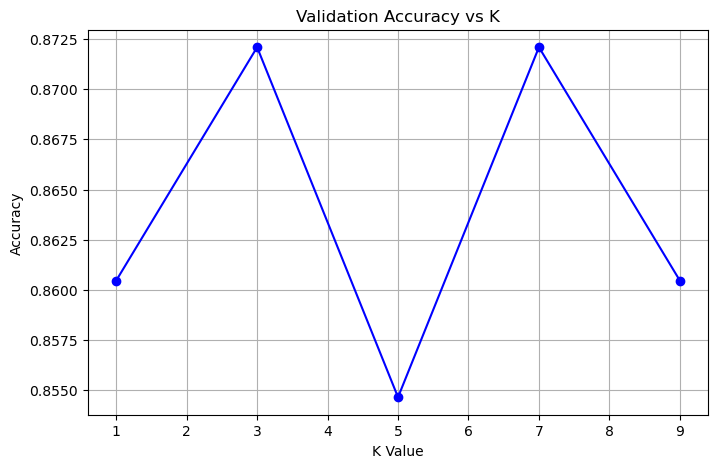


✅ Best K = 3 with Accuracy = 87.21%


In [3]:
# Try multiple k values
k_values = [1, 3, 5, 7, 9]
val_scores = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    val_scores.append(acc)
    print(f"K = {k} → Accuracy = {acc:.4f}")

# Plot validation accuracy per k
plt.figure(figsize=(8,5))
plt.plot(k_values, val_scores, marker='o', color='blue')
plt.title("Validation Accuracy vs K")
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Find best K
best_k = k_values[np.argmax(val_scores)]
print(f"\n✅ Best K = {best_k} with Accuracy = {max(val_scores)*100:.2f}%")


# Final Evaluation with Confusion Matrix

📘 Purpose:
To evaluate the final model performance using the best K value found from the previous step.

💡 Why use confusion matrix and classification report?

- Accuracy alone can be misleading, especially with imbalanced data (more Bad than Good wines).
- Confusion matrix gives insight into:
    - True positives, false negatives, etc.
    - How well each class is predicted

- Classification report provides:
    - Precision: How many predicted goods are actually good
    - Recall: How many actual goods are correctly predicted
    - F1-score: Harmonic mean of precision and recall

🧠 Insight:
- The model performs much better on the majority class (Bad wine)
- Recall for Good wine is relatively low → model struggles to identify minority class

In [4]:
# Train final KNN model using best K
final_knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
final_knn.fit(X_train, y_train)
y_pred = final_knn.predict(X_test)

# Evaluation results
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       148
           1       0.57      0.33      0.42        24

    accuracy                           0.87       172
   macro avg       0.74      0.65      0.67       172
weighted avg       0.85      0.87      0.86       172

=== Confusion Matrix ===
[[142   6]
 [ 16   8]]


# Visualize Decision Boundaries (2D PCA Projection)

📘 Purpose:
To visualize how KNN separates the classes in a 2D space using PCA.

💡 Why use PCA and visualization?
- The dataset has 11 features → not possible to visualize directly
- PCA reduces it to 2 principal components for human-friendly visualization
- Decision boundaries show how the classifier segments the space

📌 What we observe:
- There is significant overlap between classes in 2D
- This explains the difficulty KNN has in clearly separating classes — particularly the minority one

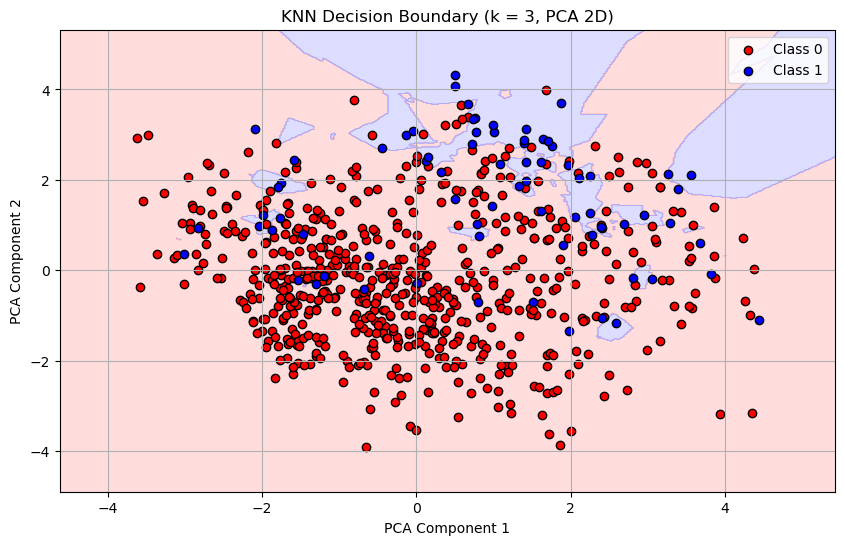

In [5]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train)
X_test_2D = pca.transform(X_test)

# Train KNN with best_k
best_k = 3  # or replace with your chosen best K
knn_2D = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
knn_2D.fit(X_train_2D, y_train)

# Create mesh grid
h = 0.02
x_min, x_max = X_train_2D[:, 0].min() - 1, X_train_2D[:, 0].max() + 1
y_min, y_max = X_train_2D[:, 1].min() - 1, X_train_2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict class for each point in the grid
Z = knn_2D.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ['red', 'blue']

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)

# Plot training points
for idx, cls in enumerate(np.unique(y_train)):
    plt.scatter(X_train_2D[y_train == cls, 0],
                X_train_2D[y_train == cls, 1],
                c=cmap_bold[idx],
                label=f'Class {cls}',
                edgecolor='k')

plt.title(f"KNN Decision Boundary (k = {best_k}, PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()